In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc




In [3]:
# load the scaler bundle once
scaler_bundle = joblib.load("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/standard_scaler_bundle.joblib")
X_train_fit_selected_scaled = scaler_bundle["X_train_fit_selected_scaled"]
X_val_selected_scaled = scaler_bundle["X_val_selected_scaled"]
X_test_selected_scaled = scaler_bundle["X_test_selected_scaled"]

# load the splits bundle once
splits_bundle = joblib.load("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/splits_bundle.joblib")
y_train_fit = splits_bundle["y_train_fit"]
y_val = splits_bundle["y_val"]
y_test = splits_bundle["y_test"]

In [4]:
X_train_benign = X_train_fit_selected_scaled[np.array(y_train_fit) == 0]
X_val_benign = X_val_selected_scaled[np.array(y_val) == 0]
n_features = X_train_benign.shape[1]
print(f"Number of benign samples for training: {len(X_train_benign)}")
print(f"Number of benign samples for validation: {len(X_val_benign)}")
print(f"Number of features: {n_features}")

Number of benign samples for training: 1292937
Number of benign samples for validation: 228166
Number of features: 40


In [5]:
inputs = keras.Input(shape=(n_features,))

# Encoder
x = layers.Dense(64, activation="relu")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.BatchNormalization()(x)

# Bottleneck
bottleneck = layers.Dense(8, activation="relu", activity_regularizer=regularizers.l1(0.00001))(x)

# Decoder
x = layers.Dense(32, activation="relu")(bottleneck)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.BatchNormalization()(x)
decoded = layers.Dense(n_features, activation="linear")(x)

ae_model = keras.Model(inputs, decoded)
ae_model.compile(optimizer="adam", loss="mse")
ae_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 40)             │         2,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,736 (41.94 KB)

 Trainable params: 10,352 (40.44 KB)

 Non-trainable params: 384 (1.50 KB)

In [6]:

history = ae_model.fit(
    X_train_benign, X_train_benign,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_benign, X_val_benign),
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=1
)

Epoch 1/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 0.3754 - val_loss: 0.3353
Epoch 2/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1397 - val_loss: 1.7840
Epoch 3/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1167 - val_loss: 0.5407
Epoch 4/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1423 - val_loss: 0.2438
Epoch 5/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.1345 - val_loss: 0.4988
Epoch 6/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0557 - val_loss: 0.5443
Epoch 7/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1128 - val_loss: 0.4180
Epoch 8/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.1031 - val_loss: 0.1599
Epoch 9/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0565 - val_loss: 3.0344
Epoch 10/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0729 - val_loss: 0.7463
Epoch 11/100
5051/5051 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0536 - val_loss: 1.2116
Epoch 12

In [7]:
# reconstruction errors on the full validation set
recon_val = ae_model.predict(X_val_selected_scaled, verbose=0)
errors_val = np.mean(np.square(X_val_selected_scaled - recon_val), axis=1)

y_val_binary = (np.array(y_val) > 0).astype(int)

In [10]:
# precision, recall, and thresholds for every possible threshold
precision, recall, thresholds = precision_recall_curve(y_val_binary, errors_val)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

In [11]:
# threshold that yields the best F1 score
best_f1_idx = np.argmax(f1_scores)
tau_ae_optimal = thresholds[best_f1_idx]

print(f"Best F1-Score on Validation Set: {f1_scores[best_f1_idx]:.4f}")
print(f"Optimal Anomaly Threshold (τ_AE) found: {tau_ae_optimal:.6f}")

Best F1-Score on Validation Set: 0.8557
Optimal Anomaly Threshold (τ_AE) found: 0.050722


In [12]:
# Evaluating Model on the Full Test Set
recon_test = ae_model.predict(X_test_selected_scaled, verbose=0)
errors_test = np.mean(np.square(X_test_selected_scaled - recon_test), axis=1)

# classifying using the new optimal threshold
ae_predictions = (errors_test > tau_ae_optimal).astype(int)

y_test_binary = (np.array(y_test) > 0).astype(int)

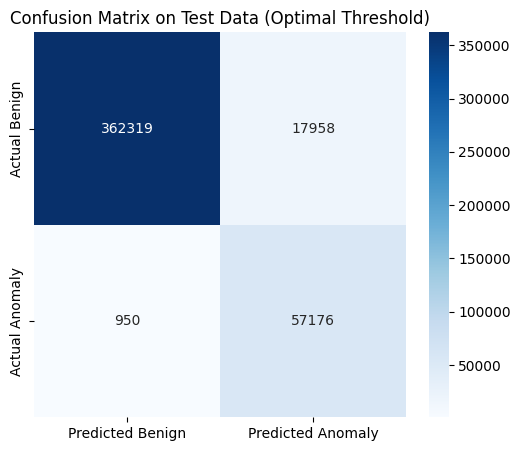

In [13]:
classification_report(y_test_binary, ae_predictions, target_names=['Benign (0)', 'Anomaly (1)'])

cm = confusion_matrix(y_test_binary, ae_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Benign', 'Predicted Anomaly'], yticklabels=['Actual Benign', 'Actual Anomaly'])
plt.title('Confusion Matrix on Test Data (Optimal Threshold)')
plt.show()

In [14]:
# save the model
ae_model.save("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/models/ae_model.keras")

Some plotting

In [15]:
CLASSIFIER_CONFIDENCE_THRESHOLD = 0.95

In [16]:
# load the trained models
ae_model = keras.models.load_model("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/models/ae_model.keras")
cnn_model = keras.models.load_model("/content/drive/MyDrive/Birkbeck Materials/CICIDS2018/artifacts/models/cnn_model.keras")

In [17]:
# CNN Classifier predictions
# CNN needs the data reshaped to (samples, features, 1)
X_test_seq = X_test_selected_scaled.to_numpy().reshape((-1, n_features, 1))
probs_test = cnn_model.predict(X_test_seq, verbose=0)
confidence_test = probs_test.max(axis=1)
predicted_class_test = probs_test.argmax(axis=1)

In [18]:
# Hybrid Decision Rule
# condition 1: The Autoencoder thinks the sample is unusual
is_unusual = errors_test > tau_ae_optimal

# condition 2: The CNN classifier is not confident that the sample is benign (class 0)
is_not_confidently_benign = ~((predicted_class_test == 0) & (confidence_test > CLASSIFIER_CONFIDENCE_THRESHOLD))

# final hybrid prediction, anomaly is flagged only if both conditions are true
hybrid_predictions = (is_unusual & is_not_confidently_benign).astype(int)

In [20]:
# evaluating the hybrid model's performance
# on test set
print(classification_report(y_test_binary, hybrid_predictions, target_names=['Benign (0)', 'Anomaly (1)']))

# confusion matrix
cm = confusion_matrix(y_test_binary, hybrid_predictions)

              precision    recall  f1-score   support

  Benign (0)       1.00      1.00      1.00    380277
 Anomaly (1)       0.99      0.98      0.99     58126

    accuracy                           1.00    438403
   macro avg       0.99      0.99      0.99    438403
weighted avg       1.00      1.00      1.00    438403



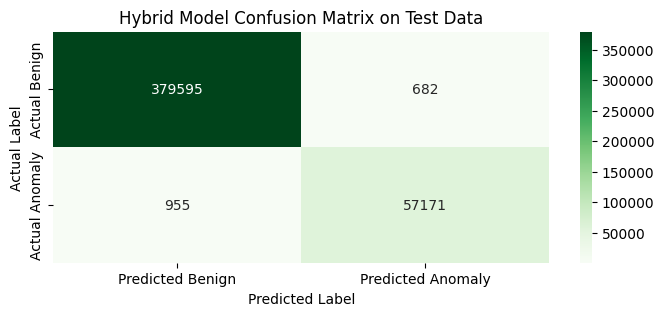

In [21]:
plt.figure(figsize=(8, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Predicted Benign', 'Predicted Anomaly'], yticklabels=['Actual Benign', 'Actual Anomaly'])
plt.title('Hybrid Model Confusion Matrix on Test Data')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

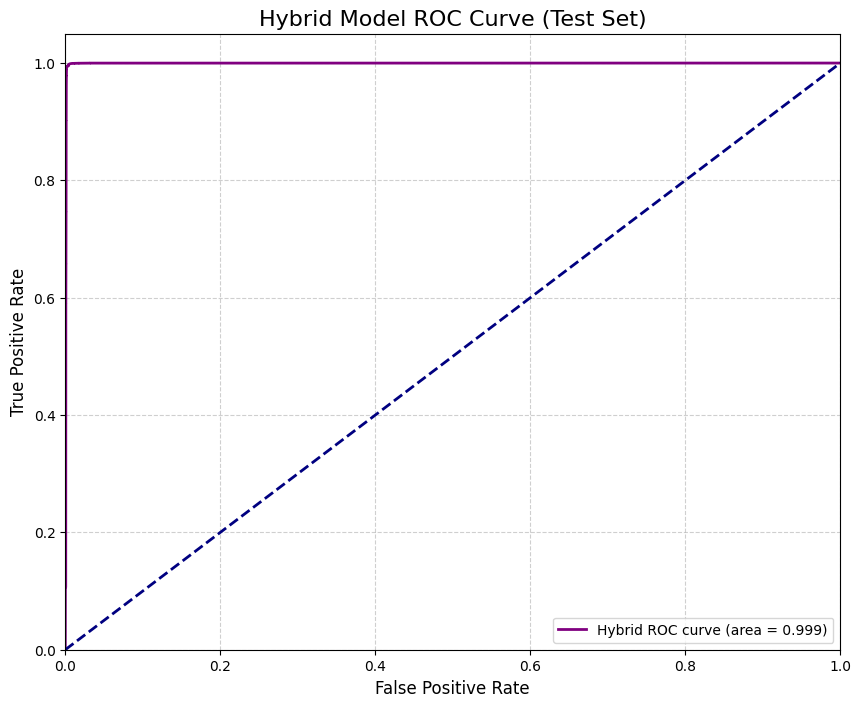

In [31]:
# --- Calculate the hybrid score ---
# Normalize errors to be roughly in the 0-1 range for better combination
confidence_benign = probs_test[:, 0] # Probability of being class 0

normalized_errors = errors_test / np.max(errors_test)
hybrid_scores = normalized_errors * (1 - confidence_benign)

# --- Calculate ROC curve and AUC using the hybrid scores ---
fpr_hybrid, tpr_hybrid, _ = roc_curve(y_test_binary, hybrid_scores)
roc_auc_hybrid = auc(fpr_hybrid, tpr_hybrid)

# --- Plot the ROC curve ---
plt.figure(figsize=(10, 8))
plt.plot(fpr_hybrid, tpr_hybrid, color='purple', lw=2, label=f'Hybrid ROC curve (area = {roc_auc_hybrid:0.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Hybrid Model ROC Curve (Test Set)', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()